# Séries temporelles et *machine learning* - TP/TD 1 <a class="tocSkip">

Ce premier TD/TP sur le machine learning pour les séries temporelles explore

1. des problèmes de classification
2. des problèmes de *forecasting*

Nous nous appuierons sur les bibliothèques `sktime` et `statsmodels`, et examinerons les méthodes de réduction, pour la classification comme pour la régression (*forecasting*), la méthode TimeSeriesForest , puis les méthodes de lissage exponentiel et ETS implémentées dans sktime et statsmodels? 

## Installations préalables

Commencer par installer `sktime` et `tsfresh`  par 
```bash
!python3 -m pip install sktime
!python3 -m pip install --upgrade statsmodels
!python3 -m pip install --upgrade tsfresh
```


**Sktime - Septembre 2021** -- sktime est _jeune_. C'est bien, mais c'est une catastrophe. A chaque nouvelle version, y compris mineure, certaines fonctions changent de nom ou sont supprimées, les paramètres modifiés, et ce sans préavis. Ce n'est pas très drôle. Le packaging peut présenter des défauts. Par exemple, dans la version 0.70, il manque un sous répertoire `datatypes` qui contient des fonctions de conversion fort utiles. Pour installer, procéder comme suit :

1. Prérequis : `python3 -m pip install --upgrade cython numba`
2. Installation à partir des sources : `python3 -m pip install git+https://github.com/alan-turing-institute/sktime.git --user`

In [1]:
#!pip3 install pandas --upgrade
#!python3 -m pip install sktime --upgrade
#!python3 -m pip install --upgrade statsmodels
#!python3 -m pip install --upgrade tsfresh

In [2]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Problèmes de classification

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sktime.transformations.panel.tsfresh import \
    TSFreshFeatureExtractor 
#from sktime.transformers.series_as_features.summarize import \
#    TSFreshFeatureExtractor was v 0.5

from sklearn.tree import DecisionTreeClassifier

Vous utiliserez les deux jeux de données suivant :

- Coffee : "FoodFood spectrographs are used in chemometrics to classify food types, a task that has obvious applications in food safety and quality assurance. The coffee data set is a two class problem to distinguish between Robusta and Aribica coffee beans. Further information can be found in the original paper Briandet et al. Discrimination of Arabica and Robusta in Instant Coffee by Fourier Transform Infrared Spectroscopy and Chemometrics J. Agricultural and Food Chemistry, 44 (1), 1996. The data was first used in the time series classification literature in Bagnall et al. Transformation Based Ensembles for Time Series Classification, SDM 2012."
- The PowerCons dataset contains the individual household electric power consumption in one year distributed in two season classes:  warm (class 1) and cold (class 2), depending on whether the power consumption is recorded during the warm seasons (from April to September) or the cold seasons (from October to March). Note that the electric power consumption profiles differ markedly within classes. The sampling rate is every ten-minute over a period of one year. Class 1: Warm season, Class 2: Cold season

### Chargement et examen des données

Vous commencerez par charger les fichiers "Coffee_TRAIN.txt" et "Coffee_TEST.txt" sous les noms de train et test. Attention, il y a quelques difficultés dans la lecture (le séparateur est deux espaces, spécifier qu'il n'y a pas de header, et utiliser `error_bad_lines=False` pour filtrer quelques lignes à problème). Dans ce tableau, la première colonne correspond aux classes recherchées, le "y", et le reste à la série temporelle elle même, le "X". 

In [4]:
cd /home/bercherj/JFB/Ens/CoursTimeSeriesEtML/

/home/bercherj/JFB/Ens/CoursTimeSeriesEtML


In [5]:
coffee = True
if coffee:
    train = pd.read_csv("Coffee/Coffee_TRAIN.txt", sep='  ', header=None, error_bad_lines=False)
    test = pd.read_csv("Coffee/Coffee_TEST.txt", sep='  ', header=None, error_bad_lines=False)
    y_train = train[0]
    X_train = train.loc[:,1:]
    y_test = test[0]
    X_test = test.loc[:,1:]
else:
    train = pd.read_csv("PowerCons/PowerCons_TRAIN.txt", sep='  ', header=None, error_bad_lines=False)
    test = pd.read_csv("PowerCons/PowerCons_TEST.txt", sep='  ', header=None, error_bad_lines=False)
    y_train = train[0]
    X_train = train.loc[:,1:]
    y_test = test[0]
    X_test = test.loc[:,1:]

<ipython-input-5-0550ffddda0e>:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  train = pd.read_csv("Coffee/Coffee_TRAIN.txt", sep='  ', header=None, error_bad_lines=False)
<ipython-input-5-0550ffddda0e>:4: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  test = pd.read_csv("Coffee/Coffee_TEST.txt", sep='  ', header=None, error_bad_lines=False)


- Extraire les séries temporelles correspondant à chacune des classes et comparez les. Le plus efficace est sans doute de tracer les moyennes des séries sur chacune des classes. 

In [6]:
idx = y_train==1

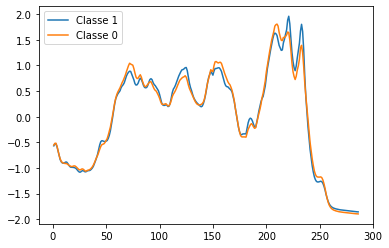

In [7]:
plt.plot(X_train.T.loc[:, idx].mean(axis=1), label="Classe 1")
plt.plot(X_train.T.loc[:, ~idx].mean(axis=1), label="Classe 0")
plt.legend()

- Pour corser un petit peu le problème, vous ajouterez un peu de bruit gaussien sur les données de test, avec un écart-type de 0.5 (données coffee) ou de 5 (powerConso). Vous appellerez par exemple `X_test_b` le tableau bruité. Comparez les deux classes sur les données de test. 

In [8]:
scale = 0.5 if coffee else 5
X_test_b = X_test + scale*np.random.randn(*X_test.shape)

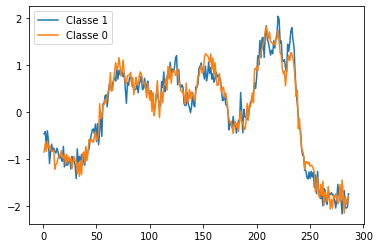

In [9]:
idx = y_test ==1
plt.plot(X_test_b.T.loc[:, idx].mean(axis=1), label="Classe 1")
plt.plot(X_test_b.T.loc[:, ~idx].mean(axis=1), label="Classe 0")
plt.legend()

### Classification avec Sklearn

Disposant des données tabulées, avec une série temporelle par ligne, on peut directement tester une classification à partir des données brutes et sans feature supplémentaire. On peut employer directement les méthodes de sklearn. 

- Vous commencerez par une méthode baseline, à titre de référence pour les comparaisons ultérieures, en utilisant 
```
from sklearn.dummy import DummyClassifier
``` 
- Vous utiliserez ensuite un `DecisionTreeClassifier` 
- Puis un `RandomForestClassifier` 
Dans tous les cas, vous effectuerez un apprentissage `.fit(..,..)` puis un calcul du score de classification. 

In [10]:
# let's get a baseline for comparison
from sklearn.dummy import DummyClassifier
classifier = DummyClassifier(strategy="prior")
classifier.fit(X_train, y_train)
classifier.score(X_test_b, y_test)

0.5357142857142857

In [11]:
from sklearn.metrics import accuracy_score
# now we can apply any scikit-learn classifier
classifier = DecisionTreeClassifier(splitter="best") #(n_estimators=100)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test_b)
accuracy_score(y_test, y_pred)

0.5714285714285714

In [12]:
from sklearn.metrics import accuracy_score
# now we can apply any scikit-learn classifier
classifier = RandomForestClassifier(n_estimators=200)
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test_b)
accuracy_score(y_test, y_pred)

0.75

- Dans le cas du classifieur RandomForest, nous avons accès à un attribut `feature_importances_`. Comparez (simplement en traçant sur le même graphique) ces features importance et l'évolution moyenne des séries temporelles, afin de constater quelles zones de la série sont les plus impliquées dans la décison. 

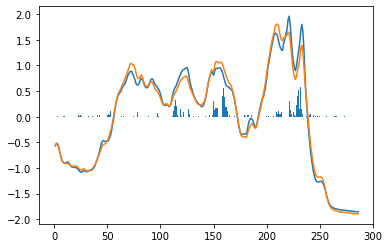

In [13]:
x = list(range(len(classifier.feature_importances_)))
plt.bar(x, 10*classifier.feature_importances_)
idx = y_train == 1
plt.plot(X_train.T.loc[:, idx].mean(axis=1))
plt.plot(X_train.T.loc[:, ~idx].mean(axis=1))

### Utilisation de sktime

Pour utiliser les fonctions de `sktime`, vous devrez mettre en forme les données sous la forme attendue par `sktime`, à savoir une colonne d'index, et une colonne par série temporelle, qui contient l'ensemble de la série (tableau numpy ou Series pandas). `sktime` fournit deux fonctions qui permettent de passer d'un dataframe "classique" à cette version et réciproquement. 

In [14]:
from sktime.datatypes._panel._convert import from_nested_to_2d_array, from_2d_array_to_nested


In [15]:
#from sktime.utils.data_container import tabularize, detabularize
# from sktime.utils.data_io import tabularize, detabularize
# C'était vrai en novembre 2020. Supprimé sans préavis ! Merci

- Créer les tables `X_train_tab` et `X_test_tab` au bon format. 

In [16]:
#X_train_tab = detabularize(X_train)
#X_test_tab = detabularize(X_test_b)

X_train_tab = from_2d_array_to_nested(X_train)
X_test_tab = from_2d_array_to_nested(X_test_b)

X_train_tab.head()

,0
0,0 -0.518419 1 -0.485884 2 -0.50500...
1,0 -0.548462 1 -0.533681 2 -0.51472...
2,0 -0.472634 1 -0.415546 2 -0.35992...
3,0 -0.509521 1 -0.484218 2 -0.47795...
4,0 -0.563427 1 -0.533896 2 -0.54382...


- Vous mettrez maintenant en oeuvre les méthodes spécifiques `TimeSeriesForestClassifier` (vue en cours, ou cf notes de cours) une méthode de plus proches voisins. 

In [17]:
from sktime.classification.compose import ComposableTimeSeriesForestClassifier as TimeSeriesForestClassifier
#from sktime.classification.interval_based import TimeSeriesForestClassifier
#from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier

   a) TimeSeriesForest

In [18]:
tsf = TimeSeriesForestClassifier()
tsf.fit(X_train_tab, y_train)
tsf.score(X_test_tab, y_test)

0.9642857142857143

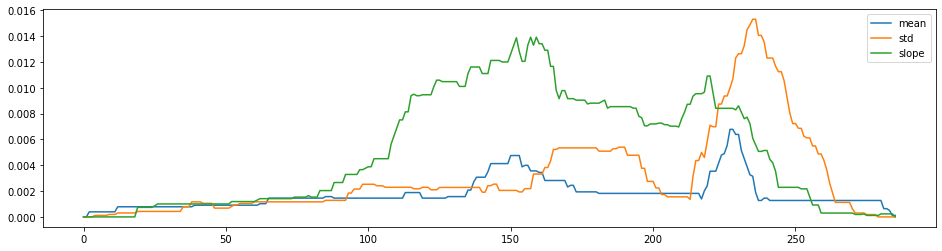

In [19]:
# Il est possible de tracer les "features importances" de la série selon
# si tsf est le nom du classifier. 
fi1 = tsf.feature_importances_;
fi1.rename(columns={"_slope": "slope"}, inplace=True)
fig, ax = plt.subplots(1, figsize=plt.figaspect(.25));
fi1.plot(ax=ax);

 b) KNeighborsTimeSeriesClassifier

In [20]:
# version 2020
"""from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")
knn.fit(X_train_tab, y_train)
knn.score(X_test_tab, y_test)"""

'from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier\nknn = KNeighborsTimeSeriesClassifier(n_neighbors=1, metric="dtw")\nknn.fit(X_train_tab, y_train)\nknn.score(X_test_tab, y_test)'

In [21]:
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=1, distance='dtw')
knn.fit(X_train_tab, y_train)
knn.score(X_test_tab, y_test)

0.7142857142857143

## Problèmes d'analyse et prédiction

On utilisera dans la suite les données sur la pandémie du coronavirus disponibles sur le site de [Johns Hopkins](https://coronavirus.jhu.edu/). Les cellules suivantes permettent de récupérer les données du jour. 

COVID DATA

In [22]:
import requests
import pandas as pd 

r = requests.get("https://raw.github.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")

with open("time_series_covid19_deaths_global_2021.csv", 'wb') as file:
    file.write(r.content)

D = pd.read_csv("time_series_covid19_deaths_global_2021.csv")
g = D.groupby("Country/Region")    

In [23]:
w = g.aggregate('sum') # regroupement selon les états d'un même pays

In [24]:
# diff pour comptage journalier (les données sont le cumul)
ww = w.loc[:,'1/22/20':].apply(lambda x: np.diff(x), axis=1) 

In [25]:
w.index

Index(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia', 'Austria',
       ...
       'United Kingdom', 'Uruguay', 'Uzbekistan', 'Vanuatu', 'Venezuela',
       'Vietnam', 'West Bank and Gaza', 'Yemen', 'Zambia', 'Zimbabwe'],
      dtype='object', name='Country/Region', length=195)

In [26]:
t  = pd.to_datetime(w.columns[2:])
bra = ww.loc['Brazil'] # ou 'US'
us = ww.loc['US'] # ou 'US'
fr = ww.loc['France'] # ou 'US'
uk = ww.loc['United Kingdom'] # ou 'US'
tn = ww.loc['Tunisia'] # ou 'US'

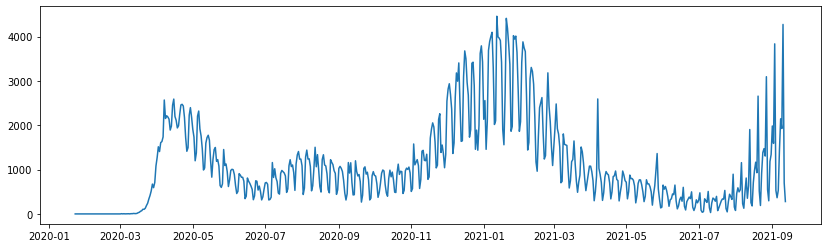

In [27]:
plt.figure(figsize=(14,4))
plt.plot(t[1:], us)

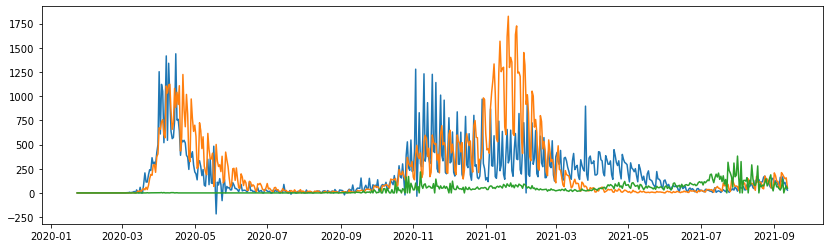

In [28]:
plt.figure(figsize=(14,4))
plt.plot(t[1:], fr)
plt.plot(t[1:], uk)
plt.plot(t[1:], tn)

### Décomposition STL 

On débute par une petite décomposition Season - Trend - residual pour ml emettre en oeuvre au moins une fois. Instanciez `STL`, fittez sur les données avec en précisant la période `period=7` et tracez les résultats en utilisant la méthode plot de l'objet résultant, disons `result`, après apprentissage. L'abjet vous permet d'accéder aux attributs `trend` et `seasonal` que vous pouvez tracer et examiner en tant que tels.   

In [29]:
#us = bra

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose, STL
result = STL(us, period=7).fit()


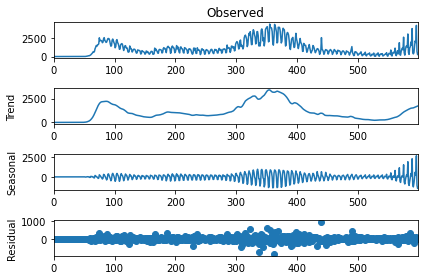

In [32]:
_ = result.plot()

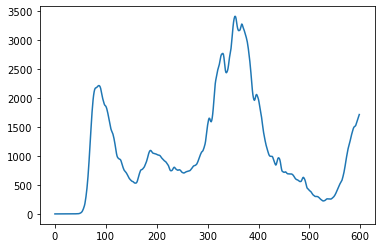

In [33]:
plt.plot(result.trend)

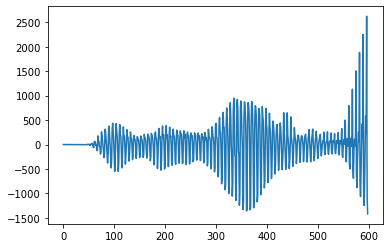

In [34]:
plt.plot(result.seasonal)

## Préparation

Vous séparerez la série en un ensemble d'apprentissage et un ensemble de test. pour cela vous utiliserez une méhode spécifique (pourquoi ?). Vous définirez votre base de test sur 36 échantillons. Les deux séries (il faut que ce soit des séries pandas), pourront être tracées conjointement à l'aide de la fonction `plot_ys`. Faites le. Dans la suite, vous utiliserez la métrique [Smape](https://en.wikipedia.org/wiki/Symmetric_mean_absolute_percentage_error) pour évaluer les performances. 

In [35]:
from sktime.forecasting.model_selection import temporal_train_test_split
#from sktime.performance_metrics.forecasting import smape_loss
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error as smape_loss
from sktime.utils.plotting import plot_series
def plot_ys(*args, **kwargs):
    # restore previous behaviour (jfb)
    nb_series=len(args)
    plot_series(*args, **kwargs, markers=['' for k in range(nb_series)])

584 15


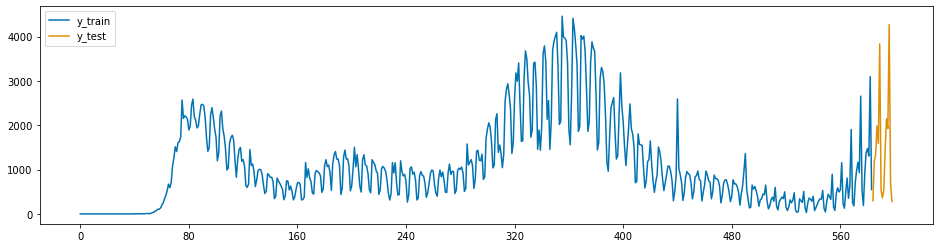

In [36]:
#y = pd.Series(index=t[1:], data=us) #index=t[1:],
y = pd.Series(data=us) #index=t[1:],
y_train, y_test = temporal_train_test_split(y, test_size=15)
plot_ys(y_train, y_test, labels=["y_train", "y_test"])
print(y_train.shape[0], y_test.shape[0])

In [37]:
# La prédiction se fait sur l'horizon suivant
fh = np.arange(1,len(y_test)+1) 

### Forecasting à l'aide de sktime, approche réduction

#### Approches naïves

Avant les approches réduction proprement dites, on commencera par des approches *naïves* : vous utiliserez le `NaiveForecaster` avec les statégies "last" et "seasonal_last". Dans les deux cas, et par la suite également : 

- instancier
- apprendre le moèle par la méthode fit, 
- prédire sur l'horizon fh, par la méthode predict
- tracer conjointement `y_train, y_test, y_pred` via la fonction `plot_ys`
- calculer l'erreur avec `smape_loss` 

In [38]:
# Pour limiter le nombre de points, on ne prend que les 200 derniers
y_train = y_train[-200:]

0.7917835865152623

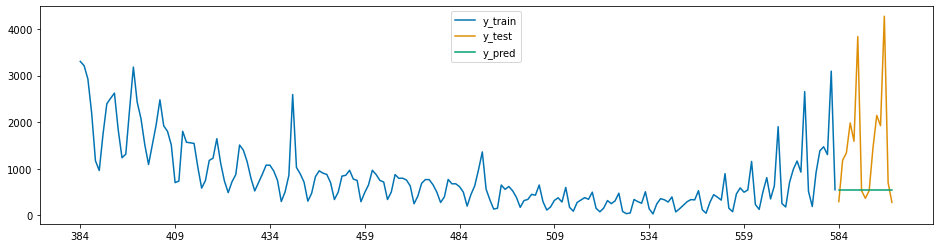

In [39]:
# using sktime 

from sktime.forecasting.naive import NaiveForecaster
forecaster = NaiveForecaster(strategy="last")
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_pred, y_test)

0.29080913296962313

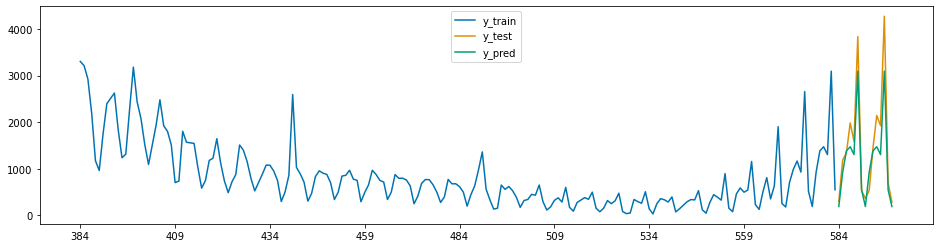

In [40]:
forecaster = NaiveForecaster(strategy='last', sp=7)
forecaster.fit(y_train)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

#### Approches réduction

En reprenant les étapes précédentes, vous évaluerez les performances pour un régresseur à plus proches voisins, puis par une forêt aléatoire. 

Vous pourrez examiner l'influence du paramètre `window_length` (à quoi sert-il ?), et du paramètre `strategy`. 


In [41]:
from sktime.forecasting.compose import ReducedForecaster as ReducedRegressionForecaster
"""The named changed to ReducedForecaster - this is a bit of an oversight on our sight. 
We shouldn't have changed the name in a minor version update. sktime is still a really young project. Some features are not consolidated yet and are likely to change in the future. – 
mloning
 """
"""DeprecationWarning: ReducedForecaster has been deprecated. 
Please use `make_reduction` from `sktime.forecasting.compose` instead."""
from sktime.forecasting.compose import make_reduction
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

0.7243566018639953

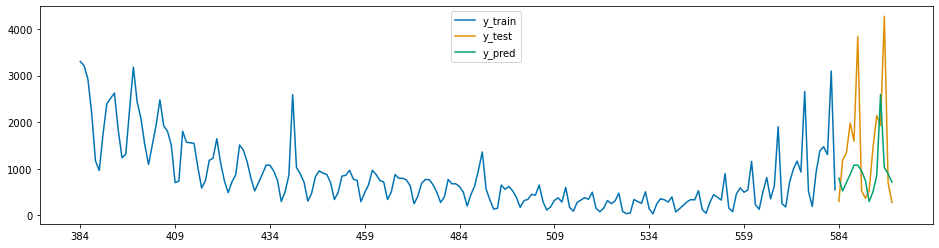

In [42]:
from sktime.forecasting.compose import ReducedForecaster as ReducedRegressionForecaster
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


regressor = KNeighborsRegressor(n_neighbors=1)
forecaster = make_reduction(estimator=regressor, 
                                         window_length=14, strategy="direct")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

0.3098890964949395

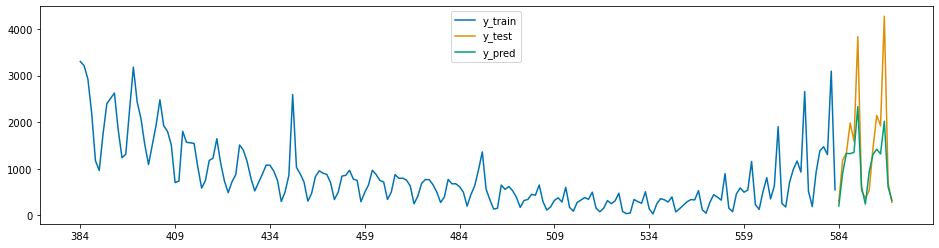

In [43]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor


regressor = RandomForestRegressor(n_estimators=200)
forecaster = make_reduction(estimator=regressor, window_length=15, 
                                         strategy="recursive")
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

**Tuning des paramètres**

Il est possible de faire du "tuning", à la fois sur les hyperparamètres de l'estimateur issu de sklearn, comme sur les paramètres de sktime (largeur de la fenêtre et stratégie). Le code vous est fourni. Cherchez à le comprendre et exécutez le. 

**/!\ LONG** Ne pas nécessairement exécuter trois cellules qui suivent

In [94]:
from sklearn.model_selection import GridSearchCV
from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import SlidingWindowSplitter, ForecastingGridSearchCV

# paramètre 'n_estimator' de scikit-learn
regressor_param_grid = {"n_estimators": [100, 200]}#, 200, 300]}
forecaster_param_grid = {"window_length": [5,  10]}#,15,25]}

# create a tunnable regressor with GridSearchCV
regressor = GridSearchCV(RandomForestRegressor(), param_grid=regressor_param_grid)
forecaster = make_reduction(
    regressor, scitype="tabular-regressor", strategy="recursive"
)
# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper=parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=forecaster_param_grid
)

0.2937518766904856


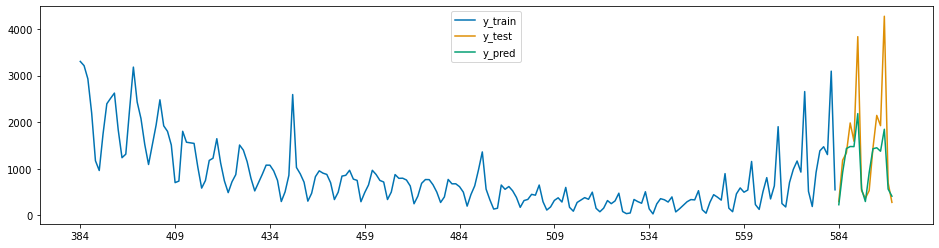

In [95]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))

In [104]:
print(gscv.best_params_)
print(gscv.best_forecaster_.estimator.estimator.get_params())

{'window_length': 10}
{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


**Pour un estimateur des plus proches voisins**

In [62]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor

from sktime.forecasting.compose import make_reduction
from sktime.forecasting.model_selection import (
    ForecastingGridSearchCV,
    SlidingWindowSplitter,
)


In [63]:
regressor = KNeighborsRegressor()
forecaster = make_reduction(regressor, window_length=15, strategy="recursive")
param_grid = {"window_length": [7, 12, 15]}

# We fit the forecaster on an initial window which is 80% of the historical data
# then use temporal sliding window cross-validation to find the optimal hyper=parameters
cv = SlidingWindowSplitter(initial_window=int(len(y_train) * 0.8), window_length=20)
gscv = ForecastingGridSearchCV(
    forecaster, strategy="refit", cv=cv, param_grid=param_grid
)

0.5171120393795677

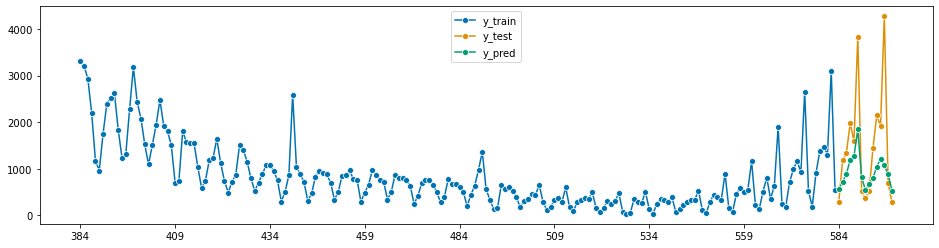

In [64]:
gscv.fit(y_train)
y_pred = gscv.predict(fh)
plot_series(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"])
smape_loss(y_pred, y_test)

In [65]:
gscv.best_params_

{'window_length': 12}

In [66]:
gscv.best_forecaster_

RecursiveTabularRegressionForecaster(estimator=KNeighborsRegressor(),
                                     window_length=12)

In [76]:
#warnings.resetwarnings()

In [77]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

### Exponential smoothing

Vous examinerez maintenant les techniques de lissage exponentiel. La librairie sktime interface les programmes de statsmodels. 

- Examinez les paramètres de `ExponentialSmoothing` et mettez en oeuvre. instanciation, fit, predict, smape_loss, et plot_ys 

In [78]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing

0.4322415000380973

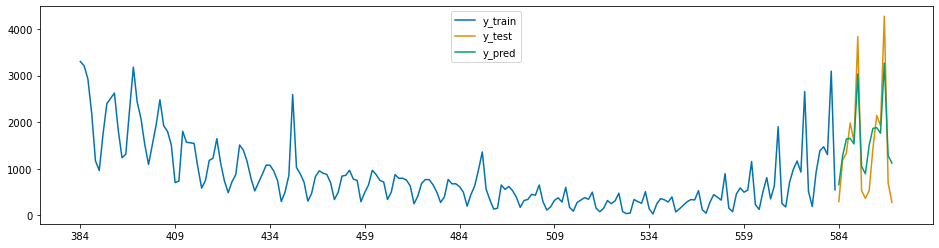

In [79]:
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
forecaster = ExponentialSmoothing(trend="add", seasonal="additive", 
                                  sp=7)
forecaster.fit(y_train, fh=fh)
y_pred = forecaster.predict(fh)
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [80]:
forecaster.get_fitted_params()

{'initial_level': 2273.3966127777735,
 'initial_slope': None,
 'initial_seasons': array([ 736.3437549 ,  522.15026639,  431.48836482,  -91.86580387,
        -785.59321107, -699.90877937,  125.25747044]),
 'aic': 2245.4432203035503,
 'bic': 2281.724711335579,
 'aicc': 2247.400209550862}

- Le lissage exponentiel peut aussi être effectué à l'aide du package `statsmodels` avec les objets `ExponentialSmoothing` et `ETSModel`. Mettre en oeuvre `ExponentialSmoothing`, puis afficher les paramètres par l'attribut `.params` de l'objet après fit.  

In [81]:
import statsmodels as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

In [82]:
fit1 = ExponentialSmoothing(y_train, seasonal_periods=7, 
                            trend='add', seasonal='add', use_boxcox=False, 
                            initialization_method="estimated").fit()


In [83]:
y_pred = fit1.forecast(15)

0.4322415000380973

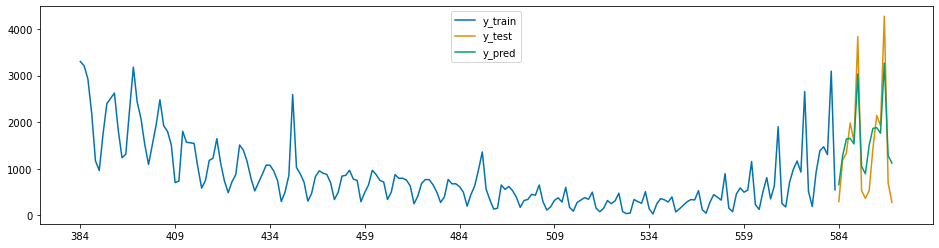

In [84]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
smape_loss(y_test, y_pred)

In [85]:
fit1.params

{'smoothing_level': 0.14156275533252144,
 'smoothing_trend': 0.07286165427265466,
 'smoothing_seasonal': 0.4622343218658849,
 'damping_trend': nan,
 'initial_level': 2273.3966127777735,
 'initial_trend': -23.21284709925112,
 'initial_seasons': array([ 736.3437549 ,  522.15026639,  431.48836482,  -91.86580387,
        -785.59321107, -699.90877937,  125.25747044]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

- On pourra utiliser la fonction `ETSModel`de statsmodels, disponible à partir de la version 0.12 . Il faut python > 3.6. 

In [86]:
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

 Mettre en oeuvre, et après fit, afficher le tableau de résultats via la méthode `.summary()`

In [87]:
model = ETSModel(y_train.astype('float64'), error="add", trend="add", seasonal="add",
                damped_trend=True, seasonal_periods=7)
fit = model.fit()

In [88]:
print(fit.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  200
Model:                      ETS(AAdA)   Log Likelihood               -1458.480
Date:                Mon, 13 Sep 2021   AIC                           2944.960
Time:                        22:22:14   BIC                           2991.136
Sample:                             0   HQIC                          2963.647
                                - 200   Scale                       126364.153
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.1200        nan        nan        nan         nan         nan
smoothing_trend       1.2e-05        nan        nan        nan         nan         nan
smoothing_seasonal  

In [89]:
y_pred = fit.forecast(15)

- Il est enfin possible, dans le cas du modèle ETS, de *simuler* des réalisations des futurs possibles. Ceci permet ainsi d'avoir une évaluation des intervalles de confiance. Pour cela, utiliser la méthode `simulate` de l'objet résultat, puis tracer les différentes séries.  

In [90]:
simulated = fit.simulate(anchor="end", nsimulations=36, repetitions=100)

0.2632057294371423


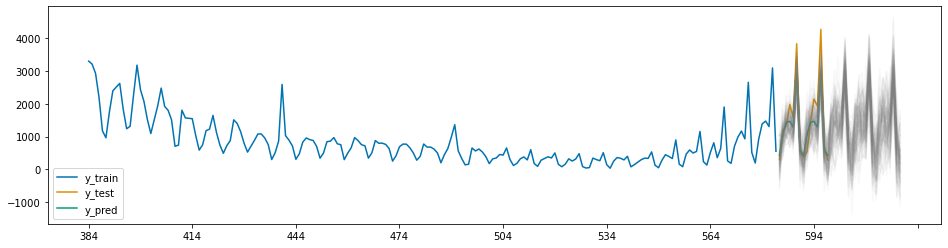

In [92]:
plot_ys(y_train, y_test, y_pred, labels=["y_train", "y_test", "y_pred"]);
print(smape_loss(y_test, y_pred))

for i in range(simulated.shape[1]):
    #simulated.iloc[:,i].plot(label='_', color='gray', alpha=0.05)
    plt.plot(simulated.index-y_train.index[0], simulated.iloc[:,i],label='_', color='gray', alpha=0.05)